<a href="https://colab.research.google.com/github/yeshwanthv5/musical_chess/blob/main/music_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import tensorflow as tf

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import numpy as np
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
import IPython.display as display

In [39]:
data_dir = '/content/drive/MyDrive/Fall 2020/CPSC 559/Project/data/images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/Fall 2020/CPSC 559/Project/data/images')

In [40]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

530


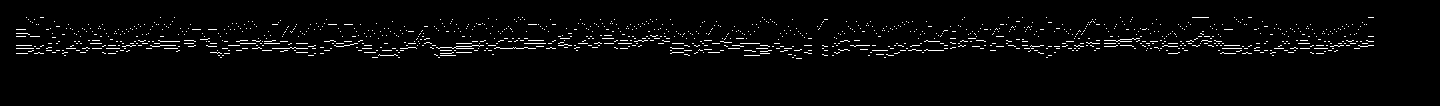

In [41]:
classical_list = list(data_dir.glob('classical/*'))
PIL.Image.open(str(classical_list[0]))

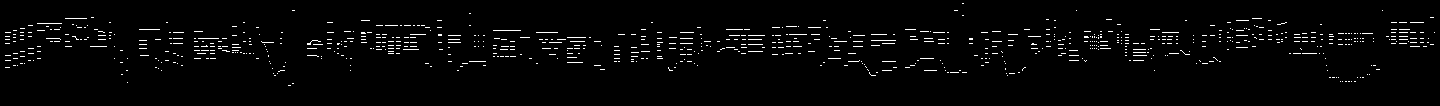

In [42]:
jazz_list = list(data_dir.glob('jazz/*'))
PIL.Image.open(str(jazz_list[0]))

In [43]:
content_image = np.asarray(PIL.Image.open(str(jazz_list[0])))
content_image = content_image[..., np.newaxis]
content_image = content_image[np.newaxis, ...]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
content_image = normalization_layer(content_image)
content_image.shape

TensorShape([1, 106, 1440, 1])

In [44]:
batch_size = 32
img_height = 107
img_width = 720*2

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 530 files belonging to 2 classes.
Using 424 files for training.


In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 530 files belonging to 2 classes.
Using 106 files for validation.


In [47]:
class_names = train_ds.class_names
print(class_names)

['classical', 'jazz']


In [48]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 107, 1440, 1)
(32,)


In [49]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [50]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
num_classes = 2
inputs = tf.keras.Input(shape=(107, 720*2, 1), name='input')
x = layers.Conv1D(32, 5, activation='relu', name = 'block1_conv1', padding='same')(inputs)
x = layers.Conv1D(32, 5, activation='relu', name = 'block1_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool1')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block2_conv1', padding='same')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block2_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool2')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block3_conv1', padding='same')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block3_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool3')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block4_conv1', padding='same')(x)
x = layers.Conv1D(32, 3, activation='relu', name = 'block4_conv2', padding='same')(x)
x = layers.AveragePooling2D(name = 'avg_pool4')(x)
x = layers.Flatten(name = 'flatten')(x)
x = layers.Dense(64, activation='relu', name = 'dense1')(x)
outputs = layers.Dense(num_classes, name = 'dense2')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="genre_classifier")

In [53]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [54]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
14/14 [==============================] - 5s 328ms/step - loss: 0.4368 - accuracy: 0.7783 - val_loss: 1.8651 - val_accuracy: 0.7358
Epoch 2/10
14/14 [==============================] - 4s 256ms/step - loss: 0.5787 - accuracy: 0.8208 - val_loss: 0.3806 - val_accuracy: 0.8396
Epoch 3/10
14/14 [==============================] - 4s 255ms/step - loss: 0.2793 - accuracy: 0.9057 - val_loss: 0.2939 - val_accuracy: 0.8774
Epoch 4/10
14/14 [==============================] - 4s 258ms/step - loss: 0.2082 - accuracy: 0.9198 - val_loss: 0.3146 - val_accuracy: 0.8679
Epoch 5/10
14/14 [==============================] - 4s 259ms/step - loss: 0.1075 - accuracy: 0.9599 - val_loss: 0.3230 - val_accuracy: 0.8774
Epoch 6/10
14/14 [==============================] - 4s 259ms/step - loss: 0.0423 - accuracy: 0.9858 - val_loss: 0.5809 - val_accuracy: 0.8679
Epoch 7/10
14/14 [==============================] - 4s 261ms/step - loss: 0.0271 - accuracy: 0.9906 - val_loss: 0.4329 - val_accuracy: 0.9057
Epoch 

In [55]:
model.summary()

Model: "genre_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 107, 1440, 1)]    0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 107, 1440, 32)     192       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 107, 1440, 32)     5152      
_________________________________________________________________
avg_pool1 (AveragePooling2D) (None, 53, 720, 32)       0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 53, 720, 32)       3104      
_________________________________________________________________
block2_conv2 (Conv1D)        (None, 53, 720, 32)       3104      
_________________________________________________________________
avg_pool2 (AveragePooling2D) (None, 26, 360, 32)  

In [56]:
print()
for layer in model.layers:
  print(layer.name)


input
block1_conv1
block1_conv2
avg_pool1
block2_conv1
block2_conv2
avg_pool2
block3_conv1
block3_conv2
avg_pool3
block4_conv1
block4_conv2
avg_pool4
flatten
dense1
dense2


In [20]:
content_layers = ['block4_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [21]:
def model_layers(layer_names, model):
  """ Creates a vgg model that returns a list of intermediate output values."""
  model.trainable = False
  
  outputs = [model.get_layer(name).output for name in layer_names]

  style_model = tf.keras.Model([model.inputs], outputs)
  return style_model

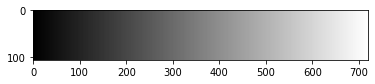

In [22]:
from PIL import Image
import numpy as np

w, h = 720, 1
x = np.linspace(0, 1, w) # Use game evaluations here
style_image = np.tile(x, (w, 1))
style_image = style_image[:107, :]
plt.imshow(style_image, cmap='gray')
plt.show()

In [23]:
style_image = style_image[..., np.newaxis]
style_image = style_image[np.newaxis, ...]
style_image.shape

(1, 107, 720, 1)

In [24]:
style_extractor = model_layers(style_layers, model)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 107, 716, 32)
  min:  0.0
  max:  137.0653
  mean:  16.10494

block2_conv1
  shape:  (1, 53, 354, 32)
  min:  0.0
  max:  115.42106
  mean:  13.287041

block3_conv1
  shape:  (1, 26, 174, 32)
  min:  0.0
  max:  127.14413
  mean:  12.698242



In [25]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [26]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.model =  model_layers(style_layers + content_layers, model)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    # preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.model(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [27]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 32, 32)
    min:  0.0
    max:  328.30814
    mean:  23.58912

   block2_conv1
    shape:  (1, 32, 32)
    min:  0.0
    max:  126.32587
    mean:  6.138858

   block3_conv1
    shape:  (1, 32, 32)
    min:  0.0
    max:  73.654526
    mean:  2.9906592

Contents:
   block4_conv2
    shape:  (1, 13, 172, 32)
    min:  0.0
    max:  12.013135
    mean:  0.20935865


In [28]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [29]:
image = tf.Variable(content_image)

In [30]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [31]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [32]:
style_weight=1e-2
content_weight=1e4

In [33]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [34]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [35]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor[...,0], 'L')

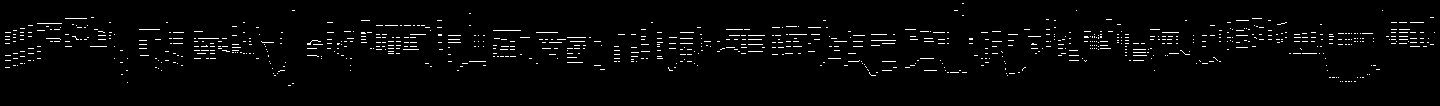

In [36]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

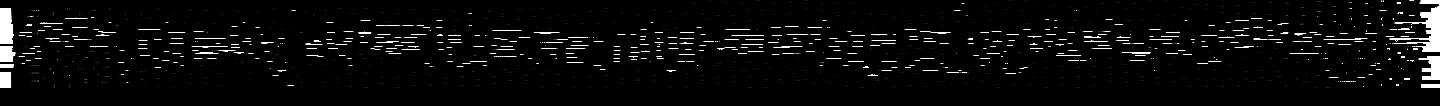

Train step: 10000
Total time: 79.9


In [37]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))